In [1]:
import numpy as np 
import pandas as pd 
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns

Using TensorFlow backend.


## list all data files in a Kaggle competition's dataset directory

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_multi_diacritics.csv
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train.csv
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map_corrected.csv
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/kalpurush-fonts/kalpurush-2.ttf


## Read four datasets related to the Bengali language

In [3]:
train_data = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv')
test_data = pd.read_csv('/kaggle/input/bengaliai-cv19/test.csv')
class_map = pd.read_csv('/kaggle/input/bengaliai-cv19/class_map.csv')
sample_submission = pd.read_csv('/kaggle/input/bengaliai-cv19/sample_submission.csv')

## Show the first 5 rows of the dataset

In [4]:
train_data.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [5]:
test_data.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [6]:
sample_submission.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


In [7]:
class_map.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


## Show the size of datasets

In [8]:
print(f'Size of training data: {train_data.shape}')
print(f'Size of test data: {test_data.shape}')
print(f'Size of class map: {class_map.shape}')

Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


## Exploratory Data Analysis

In [9]:
HEIGHT = 236
WIDTH = 236

def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map[class_map['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

def image_from_char(char):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('/kaggle/input/kalpurush-fonts/kalpurush-2.ttf', 120)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)

    return image

### Number of unique values

In [10]:
print(f'Number of unique grapheme roots: {train_data["grapheme_root"].nunique()}')
print(f'Number of unique vowel diacritic: {train_data["vowel_diacritic"].nunique()}')
print(f'Number of unique consonant diacritic: {train_data["consonant_diacritic"].nunique()}')

Number of unique grapheme roots: 168
Number of unique vowel diacritic: 11
Number of unique consonant diacritic: 7


### Show most used top 10 Grapheme Roots in training set

In [11]:
top_10_roots = get_n(train_data, 'grapheme_root', 10)
top_10_roots

,index,component,count
72,72,দ,5736
64,64,ত,5596
13,13,ক,5420
107,107,ব,5321
23,23,গ,5149
96,96,প,4926
113,113,ভ,4395
147,147,স,4392
133,133,শ,4374
115,115,ম,4015


### Show vowel Diacritic in taining data

In [12]:
top_vowels = get_n(train_data, 'vowel_diacritic', 11)
top_vowels

,index,component,count
0,168,0,41508
1,169,া,36886
7,175,ে,28723
2,170,ি,25967
4,172,ু,18848
3,171,ী,16152
9,177,ো,16032
5,173,ূ,5297
6,174,ৃ,4336
10,178,ৌ,3563


### Show consonant Diacritic in training data

In [13]:
top_consonants = get_n(train_data, 'consonant_diacritic', 5)
top_consonants

,index,component,count
0,179,0,125278
2,181,র্,23465
5,184,্র,21397
4,183,্য,21270
1,180,ঁ,7424


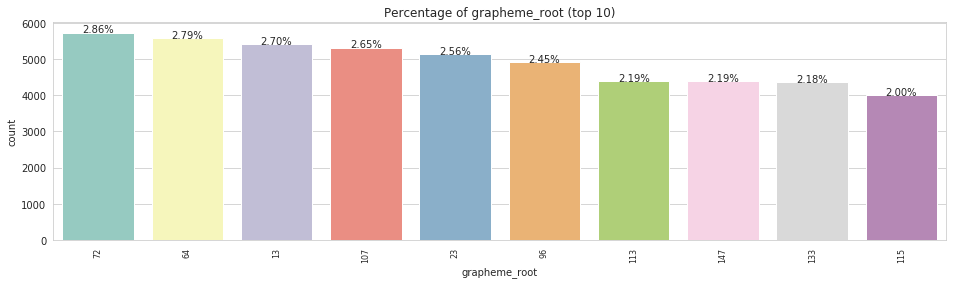

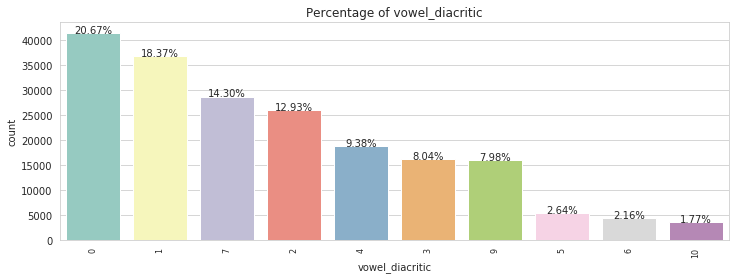

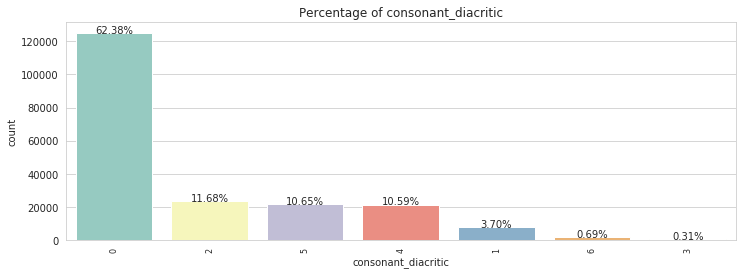

In [14]:
def plot_count(feature, title, df, size=1):
    '''
    Plot count of classes of selected feature; feature is a categorical value
    param: feature - the feature for which we present the distribution of classes
    param: title - title to show in the plot
    param: df - dataframe 
    param: size - size (from 1 to n), multiplied with 4 - size of plot
    '''
    with sns.axes_style("whitegrid"):
        f, ax = plt.subplots(1,1, figsize=(4*size,4))
        total = float(len(df))
        g = sns.countplot(df[feature], order = df[feature].value_counts().index[:10], palette='Set3')
        g.set_title("Percentage of {}".format(title))
        if(size > 2):
            plt.xticks(rotation=90, size=8)
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(100*height/total),
                    ha="center") 
        plt.show() 
    
plot_count('grapheme_root', 'grapheme_root (top 10)', train_data, size=4)
plot_count('vowel_diacritic', 'vowel_diacritic', train_data, size=3)
plot_count('consonant_diacritic', 'consonant_diacritic', train_data, size=3)

In [15]:
train_data = train_data.drop(['grapheme'], axis=1, inplace=False)

In [16]:
train_data[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_data[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [17]:
IMG_SIZE=64
N_CHANNELS=1


## Rescales a DataFrame containing an image to a specified size.

In [18]:
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

## Convert all category variables in a dataframe into dummy variables.

In [19]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

# Create Model

In [20]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Model

# Convolution, batch normalisation, ReLU activation
def conv_bn_relu(inputs, filters, kernel_size, strides=(1, 1)):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

#Basic residual blocks
def basic_block(inputs, filters, strides=(1, 1), downsample=False):
    residual = inputs
    x = conv_bn_relu(inputs, filters, kernel_size=(3, 3), strides=strides)
    x = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    
    if downsample:
        residual = Conv2D(filters=filters, kernel_size=(1, 1), strides=strides, padding="same")(inputs)
        residual = BatchNormalization()(residual)
    
    x = Add()([x, residual])
    x = Activation("relu")(x)
    return x

# Created a ResNet34 model with multiple output
def build_resnet34(input_shape=(IMG_SIZE, IMG_SIZE, 1), num_classes=1000):
    inputs = Input(shape=input_shape)

    x = conv_bn_relu(inputs, filters=64, kernel_size=(7, 7), strides=(2, 2))
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x)

    filters = 64
    for i, blocks in enumerate([3, 4, 6, 3]):  # ResNet34的块数
        for block in range(blocks):
            if block == 0 and i != 0:
                x = basic_block(x, filters=filters, strides=(2, 2), downsample=True)
            else:
                x = basic_block(x, filters=filters)
        filters *= 2
        
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)
    
    # Multiple output layer
    head_root = Dense(168, activation='softmax', name='root')(x)
    head_vowel = Dense(11, activation='softmax', name='vowel')(x)
    head_consonant = Dense(7, activation='softmax', name='consonant')(x)
    
    model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])
    
    return model

# create model
model = build_resnet34(input_shape=(IMG_SIZE, IMG_SIZE, 1), num_classes=1000)
#model.summary()


## Plot the structure of the model

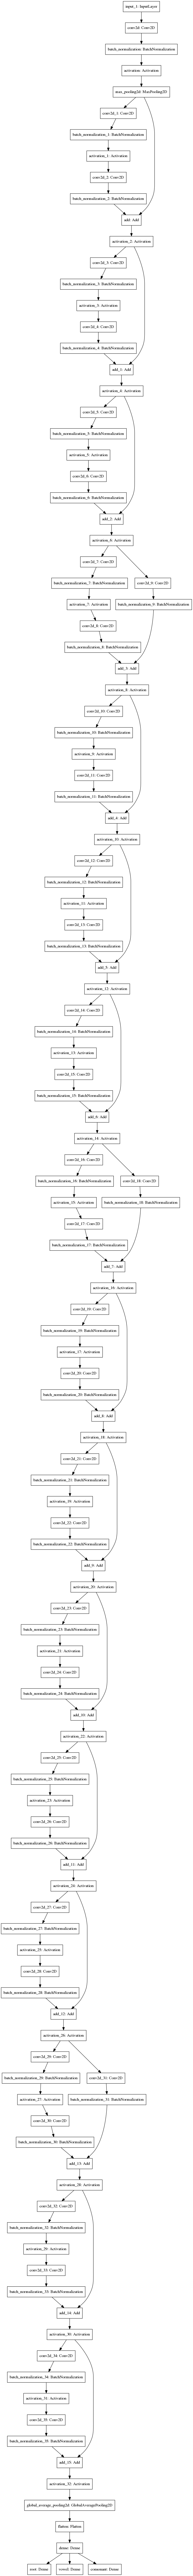

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True)

In [22]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Set a learning rate annealer

In [23]:

lr_re_root = ReduceLROnPlateau(monitor='root_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
lr_re_vowel = ReduceLROnPlateau(monitor='vowel_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
lr_re_consonant = ReduceLROnPlateau(monitor='consonant_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [24]:
# Setting hyperparameters
batch_size = 256
epochs = 50

# A custom data generator is defined and produces multiple labelled batches of data simultaneously, suitable for training multi-output models.

In [25]:
class DataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [26]:
HEIGHT = 137
WIDTH = 236

# Training

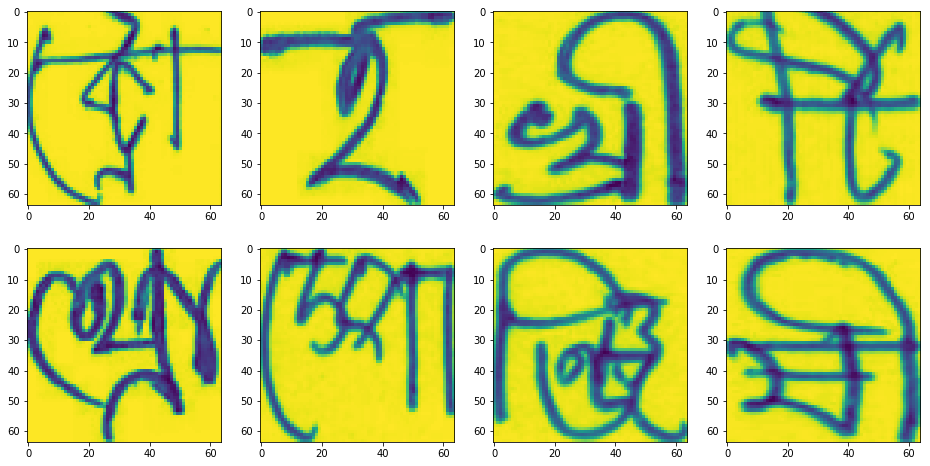


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)


In [27]:
histories = []
i=0
train_set = pd.merge(pd.read_parquet(f'/kaggle/input/bengaliai-cv19/train_image_data_{i}.parquet'), train_data, on='image_id').drop(['image_id'], axis=1)
    
 
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
count=0
for row in ax:
    for col in row:
        col.imshow(resize(train_set.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
        count += 1
plt.show()
    
X_train = train_set.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
X_train = resize(X_train)/255
    

X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
Y_train_root = pd.get_dummies(train_set['grapheme_root']).values
Y_train_vowel = pd.get_dummies(train_set['vowel_diacritic']).values
Y_train_consonant = pd.get_dummies(train_set['consonant_diacritic']).values

print(f'Training images: {X_train.shape}')
print(f'Training labels root: {Y_train_root.shape}')
print(f'Training labels vowel: {Y_train_vowel.shape}')
print(f'Training labels consonants: {Y_train_consonant.shape}')



## Divide the data into training and validation set

In [28]:
x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
del train_set
del X_train
del Y_train_root, Y_train_vowel, Y_train_consonant

## Data augmentation for creating more training data

In [29]:
datagen = DataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

# Fit the model

In [30]:
history = model.fit_generator(datagen.flow(x_train, {'root': y_train_root, 'vowel': y_train_vowel, 'consonant': y_train_consonant}, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[lr_re_root, lr_re_vowel, lr_re_consonant])

histories.append(history)
    
# Delete to reduce memory usage
del x_train
del x_test
del y_train_root
del y_test_root
del y_train_vowel
del y_test_vowel
del y_train_consonant
del y_test_consonant
gc.collect()

Train for 180 steps, validate on 4017 samples
Epoch 1/50
180/180 [==============================] - 32s 179ms/step - loss: 6.5902 - root_loss: 4.4473 - vowel_loss: 1.2477 - consonant_loss: 0.8952 - root_accuracy: 0.0521 - vowel_accuracy: 0.5747 - consonant_accuracy: 0.6962 - val_loss: 12.9139 - val_root_loss: 6.9531 - val_vowel_loss: 4.0249 - val_consonant_loss: 1.9344 - val_root_accuracy: 0.0182 - val_vowel_accuracy: 0.2367 - val_consonant_accuracy: 0.6107
Epoch 2/50
180/180 [==============================] - 23s 129ms/step - loss: 4.0466 - root_loss: 2.8991 - vowel_loss: 0.6536 - consonant_loss: 0.4940 - root_accuracy: 0.2533 - vowel_accuracy: 0.7840 - consonant_accuracy: 0.8346 - val_loss: 10.6577 - val_root_loss: 7.0827 - val_vowel_loss: 2.6239 - val_consonant_loss: 0.9520 - val_root_accuracy: 0.0958 - val_vowel_accuracy: 0.4441 - val_consonant_accuracy: 0.7548
Epoch 3/50
180/180 [==============================] - 23s 127ms/step - loss: 2.5332 - root_loss: 1.6863 - vowel_loss: 0.49

1435

## Iterative plotting of accuracy and loss for training and validation sets.

In [31]:
%matplotlib inline
def train_loss(his, epoch, title):
    plt.style.use('classic')
    plt.figure()
    #plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['root_loss'], label='train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['vowel_loss'], label='train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['consonant_loss'], label='train_consonant_loss')
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Train_Loss')
    plt.legend(loc='upper right')
    plt.show()
    
def val_loss(his, epoch, title):
    plt.style.use('classic')
    plt.figure()   
    plt.plot(np.arange(0, epoch), his.history['val_root_loss'], label='val_root_loss')
    plt.plot(np.arange(0, epoch), his.history['val_vowel_loss'], label='val_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['val_consonant_loss'], label='val_consonant_loss')
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Val_Loss')
    plt.legend(loc='upper right')
    plt.show()

def train_acc(his, epoch, title):
    plt.style.use('classic')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['root_accuracy'], label='train_root_acc')
    plt.plot(np.arange(0, epoch), his.history['vowel_accuracy'], label='train_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['consonant_accuracy'], label='train_consonant_accuracy')
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Train_Accuracy')
    plt.legend(loc='lower right')
    plt.show()
    
def val_acc(his, epoch, title):
    plt.style.use('classic')
    plt.figure()   
    plt.plot(np.arange(0, epoch), his.history['val_root_accuracy'], label='val_root_acc')
    plt.plot(np.arange(0, epoch), his.history['val_vowel_accuracy'], label='val_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['val_consonant_accuracy'], label='val_consonant_accuracy')
   
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Val_Accuracy')
    plt.legend(loc='lower right')
    plt.show()

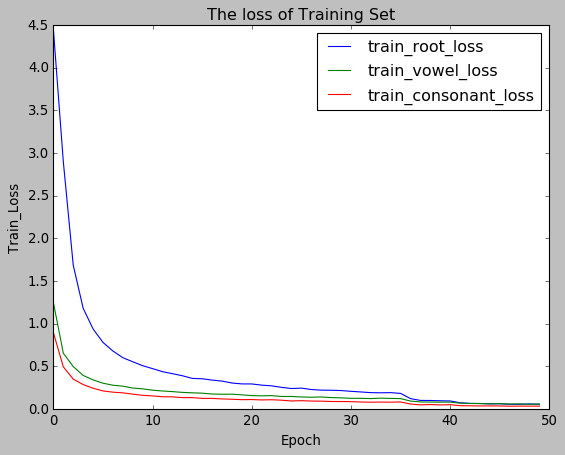

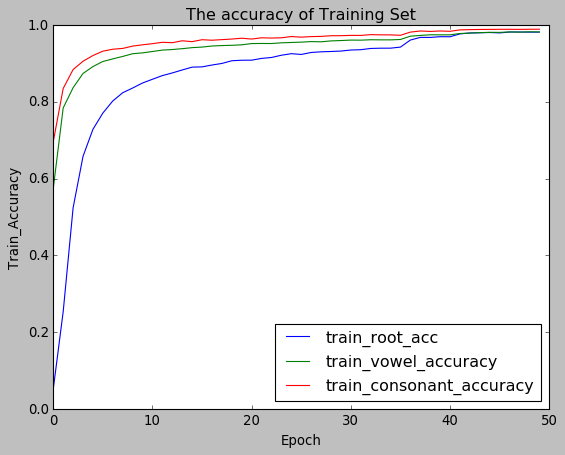

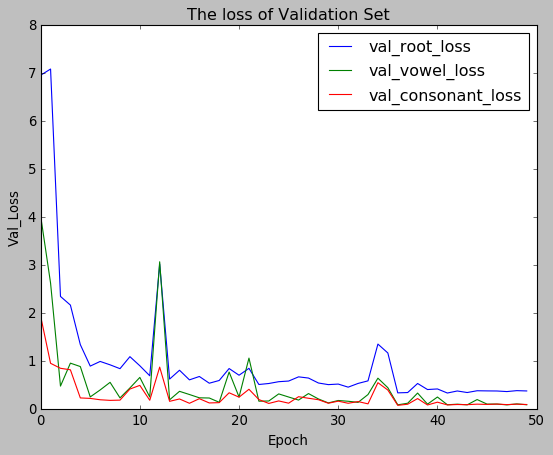

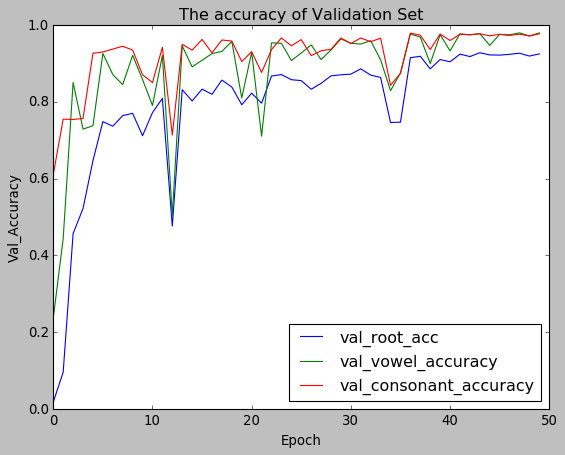

In [32]:
train_loss(histories[0], epochs, 'The loss of Training Set')
train_acc(histories[0], epochs, 'The accuracy of Training Set')
val_loss(histories[0], epochs, 'The loss of Validation Set')
val_acc(histories[0], epochs, 'The accuracy of Validation Set')

In [33]:
del histories
gc.collect()

10096

## The test data is predicted and the predictions are stored in a file called submission.csv

In [34]:
model_result = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] 
row_id=[] 
for i in range(4):
    df_test_img = pd.read_parquet('/kaggle/input/bengaliai-cv19/test_image_data_{}.parquet'.format(i)) 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    predict = model.predict(X_test)

    for i, p in enumerate(model_result):
        model_result[p] = np.argmax(predict[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(model_result[comp][k])
    del df_test_img
    del X_test
    gc.collect()
#Store the predictions in a file called submission.csv and print out the first 5 lines of data.
df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93


# Show the result

In [35]:
df_sample

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93
5,Test_1_vowel_diacritic,2
6,Test_2_consonant_diacritic,0
7,Test_2_grapheme_root,19
8,Test_2_vowel_diacritic,0
9,Test_3_consonant_diacritic,0
